<a href="https://colab.research.google.com/github/arredocana/data-analysis/blob/main/An%C3%A1lisis%20Padr%C3%B3n%20de%20Madrid%20usando%20Koalas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Configuración del entorno

Para trabajar con tu notebook en Colaboratory puedes conectarte a un entorno de ejecución **local** o en la **nube**.

En ambos casos, el notebook se guardará en tu cuenta de Google Drive en una carpeta nueva llamada **Colab Notebooks**.

No obstante, puedes descargarte el notebook a tu equipo local en formato .ipynb o .py desde la opción Archivo.

### Local (usando Jupyter)

Si decides trabajar con tu equipo local necesitarás conectarte a un servidor de **Jupyter Notebook**. Los pasos a seguir serían los siguientes:

1. Instalar [Jupyter](http://jupyter.org/install) en tu equipo local.

2. Instala y habilitar la extensión **jupyter_http_over_ws**: 

  `pip install jupyter_http_over_ws jupyter serverextension enable --py jupyter_http_over_ws`

3. Inicia el servidor y autenticarse:

  Abrir consola y ejecutar el siguiente comando:

  `jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0`

  Cuando se inicie el servidor, se mostrará un mensaje con la URL de backend inicial utilizada para la autenticación. Copia esta URL. 
  
  Ejemplo: http://localhost:8888/?token=b5caf18c5137318b8914e6881d5036e55867ef06490919dd

4. Conéctate al entorno de ejecución local:

  En Colaboratory, haz clic en el botón Conectar y selecciona Conectar a un entorno de ejecución local. 
  
  Introduce la URL del paso anterior en el cuadro de diálogo que aparece y haz clic en el botón Conectar. Después, debería establecerse la conexión con tu entorno de ejecución local.

Para más información puedes leer la [documentación oficial](https://research.google.com/colaboratory/intl/es/local-runtimes.html).

In [ ]:
# Comprobamos ruta del directorio de trabajo desde donde iniciamos Jupyter
%pwd

'C:\\Users\\antonio.arredondo\\OneDrive - Bosonit\\Spark Training\\datasets'

In [ ]:
# Local file path
file_path = "padron_madrid_2020.csv"

### Nube

Si prefieres trabajar en la **nube** aprovechando los recursos de los servidores de Google tendrás que instalar las librerías que no estén disponibles en la configuración por defecto del notebook e importar los ficheros que sean necesarios. 

Esta operación es necesaria hacerla siempre que te conectes a la nube o inicies un nuevo notebook.

#### Instalación de librerías

In [ ]:
# Install needed libraries
!pip install -q pyspark
!pip install -q pyngrok

#### Importación de datos

##### Desde Google Drive

In [ ]:
# Mount Drive (authentication required)
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Viewing the data in the folder present from the drive
!ls -l "/content/drive/My Drive/Colab Notebooks/datasets"

In [ ]:
# Cloud file path
file_path = "drive/MyDrive/Colab\ Notebooks/datasets/padron_madrid_2020.csv"

##### Desde local

In [ ]:
# Importing files method from colab for accessing Local file system
from google.colab import files

uploaded = files.upload()

Saving padron_madrid_2020.csv to padron_madrid_2020.csv


In [ ]:
uploaded.keys()

In [ ]:
# Local file path
file_path = "padron_madrid_2020.csv"

## Introducción: de Pandas a Koalas

Para los usuarios que están familiarizadas con **Pandas**, trabajar con DataFrames en **PySpark** puede ser un poco tedioso de aprender al principio debido a que su sintaxis es más cercana a SQL que al propio Python.

Hasta ahora PySpark tenía la función [`toPandas()`](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=topandas#pyspark.sql.DataFrame.toPandas) para convertir un DataFrame a Pandas.

Sin embargo, **esta función únicamente es aconsejable utilizarse cuando se trabaja con datasets pequeños** ya que carga en la memoria del nodo driver todos los datos del dataset almacenados en múltiples nodos y, si el dataset llega a ser muy grande, se producirá un error por falta de memoria.

Para comprenderlo mejor vamos a ver un ejemplo simulando que hemos cargado en Spark un dataset pequeño con 100 mil registros y otro con 100 millones:

In [ ]:
# Importamos librerías necesarias
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd

# Iniciamos la SparkSession
spark = SparkSession.builder\
        .appName("Koalas")\
        .enableHiveSupport()\
        .getOrCreate()

In [ ]:
# Creamos DataFrame en Spark con 100k filas
small_spark_DF = spark.range(10**5)

# Mostramos primeras filas del DataFrame
small_spark_DF.show(5)

# Count the number of rows 
print("Number of rows:", small_spark_DF.count())

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+
only showing top 5 rows

Number of rows: 100000


In [ ]:
# Convertimos PySpark DataFrame a Pandas DataFrame
small_pandas_DF = small_spark_DF.toPandas()

print(type(small_pandas_DF))

# Mostramos las 5 primeras filas
small_pandas_DF.head()

<class 'pandas.core.frame.DataFrame'>


,id
0,0
1,1
2,2
3,3
4,4


In [ ]:
# Creamos DataFrame en Spark con 100M filas
big_spark_DF = spark.range(10**8)

big_spark_DF.show(5)

# Count the number of rows 
print("Number of rows:", big_spark_DF.count())

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+
only showing top 5 rows

Number of rows: 100000000


En este caso si intentamos convertir nuestro DataFrame `big_spark_DF` a un DataFrame de Pandas mediante la función `toPandas()` se producirá el siguiente error por falta de memoria:

*Py4JJavaError: An error occurred while calling o30.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 9.0 failed 1 times, most recent failure: Lost task 1.0 in stage 9.0 (TID 14, 60c377ead6af, executor driver): java.lang.OutOfMemoryError: Java heap space*

In [ ]:
# Lanzará error por memoria insuficiente
# pandas_DF = big_spark_DF.toPandas()

Ya hemos visto que usar **Pandas** cuando se requiere trabajar con grandes volúmenes de datos no es eficiente, ya que carga todos los datos en una única máquina para procesarlos en lugar de aprovechar el potencial de la computación distribuida, además puede producirse un error si no hay suficiente memoria en el nodo principal.

Y aquí es donde entra en juego **Koalas**.

**Koalas** se trata de una librería nueva de Python basada en la API de Pandas que fue creada por la empresa **Databricks** (creadores de Spark) para ayudar a los usuarios que quieren hacer uso de las capacidades de computación distribuida de Spark sin tener que recurrir a las APIs de PySpark.

Actualmente en la [versión 1.6.0](https://koalas.readthedocs.io/en/latest/whatsnew/v1.6.0.html) de Koalas se tiene implementado cerca del 70% de las APIs de Pandas permitiendo que la curva de aprendizaje sea significativamente fácil para usuarios ya familiarizados con pandas.

No obstante, esto no significa que no se deba aprender PySpark ni tener un conocimiento mínimo de Spark, a pesar de que Koalas tiene prácticamente la misma API que Pandas existen diferencias "sutiles" que el usuario debe tener en cuenta cuando se trabaja en un entorno distribuido.

En conclusión, si te estás preguntando si comenzar con PySpark o Koalas en la documentación oficial recomiendan lo siguiente:

*If you are already familiar with pandas and want to leverage Spark for big data, we recommend using Koalas. If you are learning Spark from ground up, we recommend you start with PySpark’s API.*

A continuación, vamos a instalar la librería **Koalas** y convertir nuestro DataFrame con 10 millones de filas de PySpark a un DataFrame de Koalas usando el método `to_koalas()`:

### Instalación de Koalas

Koalas puede ser instalado mediante Conda o PyPI. Además también es necesario tener instalado en tu equipo una versión de Python superior a la 3.5 y las siguientes librerías:

* pyspark (versión >= 2.4.0)
* pandas (versión >= 0.23.2)
* numpy (versión >= 1.14)
* pyarrow (versión >= 1.0.0)

*Puedes comprobar la versión de una librería mediante el comando pip show library, por ejemplo: pip show pandas*

No obstante, te recomendamos que eches un vistazo a la [documentación oficial](https://koalas.readthedocs.io/en/latest/getting_started/install.html#installing-koalas) para una instalación correcta.

In [ ]:
# Instalamos librerías
!pip install koalas
!pip install -q pyarrow==1.0.0 # necesario actualizar

In [ ]:
# Importamos librería Koalas
import databricks.koalas as ks

In [ ]:
# Convertimos DataFrame de PySpark a DataFrame de Koalas (ejecutar prueba sólo en la nube)
#koalas_DF = big_spark_DF.to_koalas()

#print(type(koalas_DF))

<class 'databricks.koalas.frame.DataFrame'>


In [ ]:
# Mostramos las primeras 5 filas
#koalas_DF.head()

Gracias a Koalas hemos convertido sin problemas un DataFrame de PySpark con 100 millones de filas a un DataFrame que externamente sigue la misma estructura que Pandas (incluyendo un índice) pero internamente se comporta como un DataFrame en PySpark.

Además, recordamos que los datos están particionados y distribuidos en múltiples nodos en lugar de tenerlos en una misma máquina como en Pandas.

Destacamos algunas ventajas de Koalas:

1. Uso de lazy evaluation como Spark, es decir, sólo se ejecuta cuando es provocado por una acción.

2. No se necesita una sesión de Spark independiente para procesar el DataFrame. Koalas hace uso del SparkSession existente.

3. Koalas soporta la sintaxis SQL estándar que permite ejecutar la consulta SQL de Spark y devuelve el resultado como un DataFrame de Koalas.

4. Configurando Koalas, se puede incluso alternar el cálculo entre Pandas y Spark.

5. Los DataFrames de Koalas pueden derivarse tanto de los de Pandas como de los de PySpark.

In [ ]:
spark.stop()

## Ejemplo de análisis exploratorio con Koalas

Vamos a ver ahora un ejemplo de uso de Koalas partiendo de un dataset cargado en Spark sobre los datos del padrón municipal de Madrid.

Nuestro objetivo será intentar responder las siguientes preguntas:

* ¿Cuántos barrios tiene cada distrito?
* ¿Cuál es la edad media de los ciudadadanos en cada barrio?
* ¿Cuál es el porcentaje de españoles y extranjeros por distrito y barrio?

A lo largo de este análisis iremos comentando las diferencias que encontremos tanto en Pandas, Koalas como en PySpark.

Posteriormente practicaremos con más ejercicios con Koalas para ver las diferencias con PySpark.

In [ ]:
# Importamos librerías necesarias
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import numpy as np

# Si la versión de la librería pyarrow en tu equipo es la 3.0.0 necesitas configurar 
# la siguiente variable de entorno para trabajar con Koalas
# Tip: puedes comprobar la versión de una librería con el comando !pip show libreria
#import os
#os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import databricks.koalas as ks

In [ ]:
# Iniciamos la SparkSession
spark = SparkSession.builder\
        .appName("Koalas")\
        .enableHiveSupport()\
        .getOrCreate()

### Leyendo el dataset

In [ ]:
# Local file path
#file_path = "./datasets/padron_madrid.csv"

In [75]:
# Cargamos datos en DataFrame de PySpark
padron_SDF = (spark.read.format('csv')
            .options(header=True, 
                     delimiter=';',
                     encoding='ISO-8859-1',
                     inferSchema=True
                    )
            .load(file_path))

# Convertimos DataFrame de PySpark a Koalas
padron_KDF = padron_SDF.to_koalas()

# Opcional: cargar datos en DataFrame de Koalas
# ks.read_csv(file_path, sep=";", encoding='ISO-8859-1')

### Mostrando filas del DataFrame

Una de las primeras diferencias que nos encontramos entre PySpark y Koalas es a la hora de mostrar los datos. 

En PySpark se utiliza el método `show()` mientras que en Koalas hereda el método `head()` de Pandas (internamente usa `limit()` de PySpark):

In [76]:
# Muestra las 10 primeras filas en PySpark
padron_SDF.show(10)

+------------+--------------------+---------------+--------------------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|COD_DISTRITO|       DESC_DISTRITO|COD_DIST_BARRIO|         DESC_BARRIO|COD_BARRIO|COD_DIST_SECCION|COD_SECCION|COD_EDAD_INT|EspanolesHombres|EspanolesMujeres|ExtranjerosHombres|ExtranjerosMujeres|
+------------+--------------------+---------------+--------------------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|           1|CENTRO              |            101|PALACIO             |         1|            1006|          6|         103|            null|               1|              null|              null|
|           1|CENTRO              |            101|PALACIO             |         1|            1007|          7|           0|               1|               1|              null|                 3|
|         

In [77]:
# Muestra las 5 primeras filas en Koalas/Pandas
# También se pueden ver las  últimas filas con el método tail()
padron_KDF.head()

,COD_DISTRITO,DESC_DISTRITO,COD_DIST_BARRIO,DESC_BARRIO,COD_BARRIO,COD_DIST_SECCION,COD_SECCION,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres
0,1,CENTRO,101,PALACIO,1,1006,6,103,NaN,1.0,NaN,NaN
1,1,CENTRO,101,PALACIO,1,1007,7,0,1.0,1.0,NaN,3.0
2,1,CENTRO,101,PALACIO,1,1007,7,1,2.0,3.0,NaN,NaN
3,1,CENTRO,101,PALACIO,1,1007,7,2,1.0,4.0,NaN,NaN
4,1,CENTRO,101,PALACIO,1,1007,7,3,4.0,NaN,NaN,NaN


### Información del dataset

Para mostrar la información sobre el DataFrame podemos usar el método `print_schema()` que es propio de la API de PySpark.

*Nota: Cuando queremos aprovechar funcionalidades existentes de la API de PySpark Koalas proporciona el [spark accessor](https://koalas.readthedocs.io/en/latest/whatsnew/v1.0.0.html?highlight=spark%20accesor#spark-accessor).*

In [78]:
# Mostramos esquema como en PySpark
padron_KDF.spark.print_schema()

root
 |-- COD_DISTRITO: integer (nullable = true)
 |-- DESC_DISTRITO: string (nullable = true)
 |-- COD_DIST_BARRIO: integer (nullable = true)
 |-- DESC_BARRIO: string (nullable = true)
 |-- COD_BARRIO: integer (nullable = true)
 |-- COD_DIST_SECCION: integer (nullable = true)
 |-- COD_SECCION: integer (nullable = true)
 |-- COD_EDAD_INT: integer (nullable = true)
 |-- EspanolesHombres: integer (nullable = true)
 |-- EspanolesMujeres: integer (nullable = true)
 |-- ExtranjerosHombres: integer (nullable = true)
 |-- ExtranjerosMujeres: integer (nullable = true)



El método "equivalente" en Pandas sería `info()` que, como podéis observar, ofrece mucha más información:

In [79]:
# Información del dataframe usando la API de Pandas
padron_KDF.info()

<class 'databricks.koalas.frame.DataFrame'>
Int64Index: 237675 entries, 0 to 237674
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   COD_DISTRITO        237675 non-null  int32 
 1   DESC_DISTRITO       237675 non-null  object
 2   COD_DIST_BARRIO     237675 non-null  int32 
 3   DESC_BARRIO         237675 non-null  object
 4   COD_BARRIO          237675 non-null  int32 
 5   COD_DIST_SECCION    237675 non-null  int32 
 6   COD_SECCION         237675 non-null  int32 
 7   COD_EDAD_INT        237675 non-null  int32 
 8   EspanolesHombres    221328 non-null  int32 
 9   EspanolesMujeres    231804 non-null  int32 
 10  ExtranjerosHombres  104618 non-null  int32 
 11  ExtranjerosMujeres  115649 non-null  int32 
dtypes: int32(10), object(2)

### Número de columnas

Igualmente si queremos comprobar el número de filas que tiene el dataframe se utilizan diferentes métodos:

**PySpark** usa el método `count()` mientras que en **Koalas** puede usarse la función `len()` o el atributo `shape` que devuelve un array con 2 elementos: nº de filas y nº de columnas del DataFrame.

El método `count()` en **Koalas** devuelve el número de filas no nulas de cada columna del DataFrame.

In [80]:
# Número de filas en PySpark
#print(f"Hay {padron_SDF.count()} registros en el dataset del padrón./n")

# Número de filas en Koalas/Pandas
print(f"Hay {len(padron_KDF)} registros en el dataset del padrón.")

Hay 237675 registros en el dataset del padrón.


In [81]:
# En Koalas la función count() devuelve el número de filas no nulas 
padron_KDF.count()

COD_DISTRITO          237675
DESC_DISTRITO         237675
COD_DIST_BARRIO       237675
DESC_BARRIO           237675
COD_BARRIO            237675
COD_DIST_SECCION      237675
COD_SECCION           237675
COD_EDAD_INT          237675
EspanolesHombres      221328
EspanolesMujeres      231804
ExtranjerosHombres    104618
ExtranjerosMujeres    115649
dtype: int64

### Reemplazando valores nulos

Algunas columnas contienen un menor número de filas porque contienen valores nulos. 

En Koalas podemos comprobar fácilmente cuántos valores nulos tiene cada columna usando el método `isnull()` seguido de `sum()`:

In [82]:
# Contar número de valores nulo en cada columna en Koalas DataFrame
padron_KDF.isnull().sum()

COD_DISTRITO               0
DESC_DISTRITO              0
COD_DIST_BARRIO            0
DESC_BARRIO                0
COD_BARRIO                 0
COD_DIST_SECCION           0
COD_SECCION                0
COD_EDAD_INT               0
EspanolesHombres       16347
EspanolesMujeres        5871
ExtranjerosHombres    133057
ExtranjerosMujeres    122026
dtype: int64

In [83]:
# Contar número de valores nulo en cada columna en PySpark DataFrame
padron_SDF.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) \
                   for c in padron_SDF.columns]).show()

+------------+-------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|COD_DISTRITO|DESC_DISTRITO|COD_DIST_BARRIO|DESC_BARRIO|COD_BARRIO|COD_DIST_SECCION|COD_SECCION|COD_EDAD_INT|EspanolesHombres|EspanolesMujeres|ExtranjerosHombres|ExtranjerosMujeres|
+------------+-------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|           0|            0|              0|          0|         0|               0|          0|           0|           16347|            5871|            133057|            122026|
+------------+-------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+



Para reemplazar los valores nulos podemos utilizar el método [fillna()](https://koalas.readthedocs.io/en/latest/reference/api/databricks.koalas.DataFrame.fillna.html) en PySpark y en Koalas.

Sin embargo, **este método no es recomendable utilizarse en datasets grandes** como advierten en la documentación de Koalas:

*Note: the current implementation of ‘method’ parameter in fillna uses Spark’s Window without specifying partition specification. This leads to move all data into single partition in single machine and could cause serious performance degradation. Avoid this method against very large dataset.*

In [84]:
# Reemplazar valores nulos en DataFrame de PySpark
padron_SDF = padron_SDF.fillna(0)

# Reemplazar valores nulos en DataFrame de Koalas
padron_KDF = padron_KDF.fillna(0)

### Seleccionando, ordenando y filtrando datos

Si queremos ver los datos de algunas columnas específicas del DataFrame en Spark utilizamos `select()` mientras que en Koalas/Pandas se usan corchetes (más info [aquí](https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/03_subset_data.html?highlight=filter#how-do-i-filter-specific-rows-from-a-dataframe)):

In [85]:
padron_SDF.select("DESC_DISTRITO", "DESC_BARRIO").show(5)

+--------------------+--------------------+
|       DESC_DISTRITO|         DESC_BARRIO|
+--------------------+--------------------+
|CENTRO              |PALACIO             |
|CENTRO              |PALACIO             |
|CENTRO              |PALACIO             |
|CENTRO              |PALACIO             |
|CENTRO              |PALACIO             |
+--------------------+--------------------+
only showing top 5 rows



In [86]:
padron_KDF[["DESC_DISTRITO", "DESC_BARRIO"]].head()

,DESC_DISTRITO,DESC_BARRIO
0,CENTRO,PALACIO
1,CENTRO,PALACIO
2,CENTRO,PALACIO
3,CENTRO,PALACIO
4,CENTRO,PALACIO


Para ordenar los datos en un DataFrame por los valores de una columna en Spark usamos el método `orderBy()` mientras que en Koalas usaríamos `sort_values()`:

In [87]:
# PySpark
padron_SDF.orderBy("EspanolesHombres", ascending=False).show(5)

+------------+--------------------+---------------+--------------------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|COD_DISTRITO|       DESC_DISTRITO|COD_DIST_BARRIO|         DESC_BARRIO|COD_BARRIO|COD_DIST_SECCION|COD_SECCION|COD_EDAD_INT|EspanolesHombres|EspanolesMujeres|ExtranjerosHombres|ExtranjerosMujeres|
+------------+--------------------+---------------+--------------------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|          16|HORTALEZA           |           1606|VALDEFUENTES        |         6|           16124|        124|          38|              99|              81|                 6|                15|
|          16|HORTALEZA           |           1606|VALDEFUENTES        |         6|           16124|        124|          39|              95|              92|                 7|                 6|
|         

In [88]:
# Koalas
padron_KDF.sort_values(by='EspanolesHombres', ascending=False).head()

,COD_DISTRITO,DESC_DISTRITO,COD_DIST_BARRIO,DESC_BARRIO,COD_BARRIO,COD_DIST_SECCION,COD_SECCION,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres
204776,16,HORTALEZA,1606,VALDEFUENTES,6,16124,124,38,99,81,6,15
204777,16,HORTALEZA,1606,VALDEFUENTES,6,16124,124,39,95,92,7,6
205234,16,HORTALEZA,1606,VALDEFUENTES,6,16129,129,37,91,96,3,9
205237,16,HORTALEZA,1606,VALDEFUENTES,6,16129,129,40,90,69,7,8
205199,16,HORTALEZA,1606,VALDEFUENTES,6,16129,129,2,88,81,3,0


Para filtrar filas basadas en una condición en Koalas también usamos corchetes mientras que en Spark usamos el método `filter()`:

In [89]:
# PySpark
padron_SDF.filter(F.col("COD_EDAD_INT") == 50).show(3)

+------------+--------------------+---------------+--------------------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|COD_DISTRITO|       DESC_DISTRITO|COD_DIST_BARRIO|         DESC_BARRIO|COD_BARRIO|COD_DIST_SECCION|COD_SECCION|COD_EDAD_INT|EspanolesHombres|EspanolesMujeres|ExtranjerosHombres|ExtranjerosMujeres|
+------------+--------------------+---------------+--------------------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|           1|CENTRO              |            101|PALACIO             |         1|            1007|          7|          50|               9|               7|                 0|                 0|
|           1|CENTRO              |            101|PALACIO             |         1|            1008|          8|          50|               5|               6|                 0|                 1|
|         

In [90]:
# Koalas
padron_KDF[padron_KDF["COD_EDAD_INT"] == 50].head(3)

,COD_DISTRITO,DESC_DISTRITO,COD_DIST_BARRIO,DESC_BARRIO,COD_BARRIO,COD_DIST_SECCION,COD_SECCION,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres
51,1,CENTRO,101,PALACIO,1,1007,7,50,9,7,0,0
148,1,CENTRO,101,PALACIO,1,1008,8,50,5,6,0,1
245,1,CENTRO,101,PALACIO,1,1009,9,50,13,7,3,1


Por otro lado, comprobamos que si intentamos filtrar por distritos o barrios veremos que no se muestra ningún resultado.

Esto se debe a que los registros de los campos `DESC_DISTRITO` y `DESC_BARRIO` fueron añadidos con un espacio extra.

In [91]:
padron_KDF[padron_KDF['DESC_DISTRITO'] == "CENTRO"].head()

,COD_DISTRITO,DESC_DISTRITO,COD_DIST_BARRIO,DESC_BARRIO,COD_BARRIO,COD_DIST_SECCION,COD_SECCION,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres


### Eliminando espacios innecesarios

Acabamos de ver que nuestro dataset contiene registros con espacios extras, para solucionarlo usaremos en PySpark la función `trim()` para cada columna mientras que en Koalas/Pandas podemos utilizar [`strip()`](https://koalas.readthedocs.io/en/latest/reference/api/databricks.koalas.Series.str.strip.html?highlight=strip#databricks.koalas.Series.str.strip):

In [92]:
# Limpiamos DataFrame eliminando espacios extras y seleccionamos las columnas necesarias
padron_SDF = padron_SDF.select(
    F.trim(F.col("desc_distrito")).alias("distrito"),
    F.trim(F.col("desc_barrio")).alias("barrio"),
    "cod_edad_int","espanoleshombres", "espanolesmujeres",
    "extranjeroshombres", "extranjerosmujeres")

In [93]:
padron_SDF.show(3)

+--------+-------+------------+----------------+----------------+------------------+------------------+
|distrito| barrio|cod_edad_int|espanoleshombres|espanolesmujeres|extranjeroshombres|extranjerosmujeres|
+--------+-------+------------+----------------+----------------+------------------+------------------+
|  CENTRO|PALACIO|         103|               0|               1|                 0|                 0|
|  CENTRO|PALACIO|           0|               1|               1|                 0|                 3|
|  CENTRO|PALACIO|           1|               2|               3|                 0|                 0|
+--------+-------+------------+----------------+----------------+------------------+------------------+
only showing top 3 rows



In [94]:
# Ejemplo de uso de la función strip() en Koalas
padron_KDF["DESC_DISTRITO"].head(5).str.strip()

# padron_KDF["DESC_DISTRITO"] = padron_KDF["DESC_DISTRITO"].str.strip()
# padron_KDF["DESC_BARRIO"] = padron_KDF["DESC_BARRIO"].str.strip()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/functions.py:392: UserWarning:

In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.



0    CENTRO
1    CENTRO
2    CENTRO
3    CENTRO
4    CENTRO
Name: DESC_DISTRITO, dtype: object

Opcionalmente en Koalas también podemos crear una función genérica que seleccione las columnas de tipo string (object) y le aplique el método strip() a cada una de ellas:

In [95]:
# Función para eliminar espacios en columnas de texto
def df_strip(df):
  ks.set_option('compute.ops_on_diff_frames', True)
  df_obj = df.select_dtypes(['object'])
  df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
  ks.set_option('compute.ops_on_diff_frames', False)
  return df

# Aviso:
# Por defecto Koalas tiene desactivado las operaciones que combinan series o dataframes diferentes
# para permitirlas tienes que habilitar la opción compute.ops_on_diff_frames
# No obstante no se recomienda en datasets grandes
# https://koalas.readthedocs.io/en/latest/user_guide/options.html#operations-on-different-dataframes

# Probar ejemplo:
# kdf = ks.DataFrame({'random': np.random.rand(padron_KDF.shape[0])})
# padronKDF["total_random"] = padronKDF["esp_hombres"] + kdf["random"]

In [96]:
# Limpiamos DataFrame de Koalas 
padron_KDF = df_strip(padron_KDF)

In [97]:
# Comprobamos que se puede filtrar correctamente
padron_KDF[padron_KDF['DESC_DISTRITO'] == "CENTRO"].head()

,COD_DISTRITO,DESC_DISTRITO,COD_DIST_BARRIO,DESC_BARRIO,COD_BARRIO,COD_DIST_SECCION,COD_SECCION,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres
0,1,CENTRO,101,PALACIO,1,1006,6,103,0,1,0,0
1,1,CENTRO,101,PALACIO,1,1007,7,0,1,1,0,3
2,1,CENTRO,101,PALACIO,1,1007,7,1,2,3,0,0
3,1,CENTRO,101,PALACIO,1,1007,7,2,1,4,0,0
4,1,CENTRO,101,PALACIO,1,1007,7,3,4,0,0,0


### Eliminando columnas

Finalmente vamos a eliminar algunas columnas del DataFrame que no vamos a utilizar en este análisis. Para ello usaremos el método [`drop()`](https://koalas.readthedocs.io/en/latest/reference/api/databricks.koalas.DataFrame.drop.html?highlight=drop#databricks.koalas.DataFrame.drop). 

*Debes saber que actualmente en Koalas solo es válido para eliminar columnas (axis=1) y no filas (axis=0):*

In [98]:
# Eliminamos columnas del DataFrame de Koalas
padron_KDF = padron_KDF.drop(["COD_DISTRITO", "COD_BARRIO", "COD_DIST_BARRIO", "COD_DIST_SECCION",
                              "COD_SECCION"], axis=1)

In [99]:
padron_KDF.head()

,DESC_DISTRITO,DESC_BARRIO,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres
0,CENTRO,PALACIO,103,0,1,0,0
1,CENTRO,PALACIO,0,1,1,0,3
2,CENTRO,PALACIO,1,2,3,0,0
3,CENTRO,PALACIO,2,1,4,0,0
4,CENTRO,PALACIO,3,4,0,0,0


### Visualizando datos

Para visualizar datos Koalas ejecuta de fondo [Plotly](https://plotly.com/python/getting-started/), una librería gráfica interactiva muy potente desarrollada por el mismo equipo de [Dash](https://plotly.com/python/bar-charts/#what-about-dash).

In [102]:
# Ejemplo de gráfico interactivo usando Plotly
kdf = ks.DataFrame({
    'a': [1, 2, 2.5, 3, 3.5, 4, 5],
    'b': [1, 2, 3, 4, 5, 6, 7],
    'c': [0.5, 1, 1.5, 2, 2.5, 3, 3.5]})

kdf.plot.hist()

Si no estás familiarizado con Plotly también puedes recurrir a [Matplotlib](https://matplotlib.org/stable/index.html) cambiando la librería que usa Koalas de fondo:

In [103]:
ks.options.plotting.backend = "matplotlib"

Vamos a ver un ejemplo de visualización de datos usando el dataset del padrón para representar el número de barrios que tiene cada distrito:

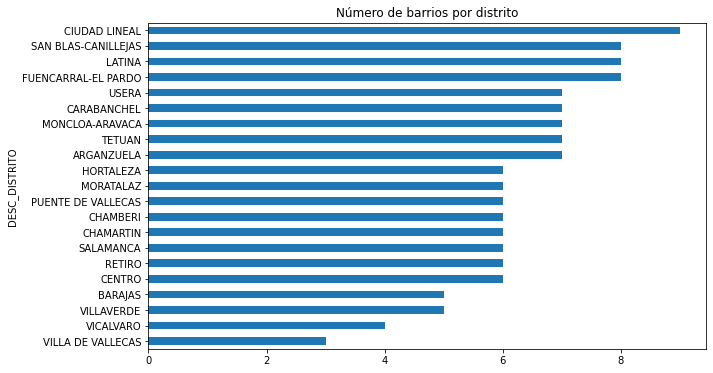

In [104]:
num_barrios = padron_KDF.groupby("DESC_DISTRITO")["DESC_BARRIO"].nunique().sort_values()

num_barrios.plot.barh(figsize=(10,6), title="Número de barrios por distrito")

### Índices por defecto

Si hasta ahora no te habías dado cuenta, cuando convertimos el DataFrame de PySpark a Koalas se añadió una columna nueva con un índice de la tabla:

In [ ]:
padron_KDF.head()

,DESC_DISTRITO,DESC_BARRIO,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres
0,CENTRO,PALACIO,103,0,1,0,0
1,CENTRO,PALACIO,0,1,1,0,3
2,CENTRO,PALACIO,1,2,3,0,0
3,CENTRO,PALACIO,2,1,4,0,0
4,CENTRO,PALACIO,3,4,0,0,0


In [ ]:
# Para acceder al index se usa el atributo index
padron_KDF.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=1000)
Showing only the first 1000

Al igual que en Pandas mediante el índice podremos seleccionar especificas filas de nuestro DataFrame mediante los métodos `iloc()` y `loc` (más info [aquí](https://www.geeksforgeeks.org/difference-between-loc-and-iloc-in-pandas-dataframe/)):

In [ ]:
padron_KDF.loc[5:8, ["DESC_DISTRITO", "DESC_BARRIO"]]

,DESC_DISTRITO,DESC_BARRIO
5,CENTRO,PALACIO
6,CENTRO,PALACIO
7,CENTRO,PALACIO
8,CENTRO,PALACIO


In [ ]:
padron_KDF.iloc[5:8]

,DESC_DISTRITO,DESC_BARRIO,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres
5,CENTRO,PALACIO,4,1,2,0,1
6,CENTRO,PALACIO,5,2,6,0,0
7,CENTRO,PALACIO,6,1,0,0,0


Este índice se crea por defecto en una nueva columna cuando convertimos un DataFrame de PySpark a Koalas sino se especifica la columna usada como índice con el parámetro `index_col`.

Si el dataset es muy grande la creación de una nueva columna puede afectar al rendimiento, por este motivo, se recomienda especificar el índice al convertir desde un DataFrame de PySpark.

Por ejemplo, podríamos haber indicado que la columna `COD_DISTRITO` fuera el índice del DataFrame en Koala:

In [ ]:
#padron_SDF.to_koalas(index_col="COD_DISTRITO")

En Koalas hay 3 tipos de índice por defecto: **secuencial**, **distribuido-secuencial** y **distribuido**.

Cuando convertimos un DataFrame a Koalas, se utiliza por defecto el índice secuencial pero se puede configurar otro tipo mediante la instrucción:

`ks.set_option('compute.default_index_type', 'sequence')` o `ks.options.compute.default_index_type = 'sequence'`

En este ejemplo se ha utilizado el **índice secuencial** que implementa una secuencia incremental de uno en uno.

Sin embargo, utiliza internamente una función de ventana no particionada de PySpark, lo que significa que todos los datos deben ser recogidos en un solo nodo. 

Si el nodo no tiene suficiente memoria, el rendimiento se degradará significativamente o se producirá un error por falta de memoria (OutOfMemoryError).

Por esta razón si trabajamos con datasets de mayor tamaño se recomienda utilizar un índice **secuencial-distribuido** o **distribuido**.

Cada tipo de índice tiene distintas características y limitaciones que pueden afectar al rendimiento por esta razón recomendamos leer la [documentación oficial](https://koalas.readthedocs.io/en/latest/user_guide/options.html#default-index-type) de Koalas para saber cuál escoger en cada situación.

En la siguiente tabla podemos ver una comparativa rápida:

|                      | Distributed computation     | Map-side operation                  | Continuous increment | Performance           |
|----------------------|-----------------------------|-------------------------------------|----------------------|-----------------------|
| sequence             | No, in a single worker node | No, requires a shuffle              | Yes                  | Bad for large dataset |
| distributed-sequence | Yes                         | Yes, but requires another Spark job | Yes, in most cases   | Good enough           |
| distributed          | Yes                         | Yes                                 | No                   | Good                  |

In [ ]:
# Creamos DataFrame en Spark con 100M filas
#big_spark_DF2 = spark.range(10**10)

In [ ]:
#ks.set_option('compute.default_index_type', 'distributed-sequence')
#kdf = big_spark_DF2.to_koalas()
#ks.reset_option('compute.default_index_type')

### Respondiendo a las preguntas iniciales

#### Número de barrios por distrito

In [51]:
# PySpark
padron_SDF.groupBy("distrito").agg(
    (F.countDistinct("barrio")).alias("total_barrios"))\
    .orderBy("total_barrios", ascending=False)\
    .show()

+-------------------+-------------+
|           distrito|total_barrios|
+-------------------+-------------+
|      CIUDAD LINEAL|            9|
|             LATINA|            8|
|FUENCARRAL-EL PARDO|            8|
|SAN BLAS-CANILLEJAS|            8|
|              USERA|            7|
|             TETUAN|            7|
|    MONCLOA-ARAVACA|            7|
|        CARABANCHEL|            7|
|         ARGANZUELA|            7|
|             RETIRO|            6|
|          SALAMANCA|            6|
| PUENTE DE VALLECAS|            6|
|             CENTRO|            6|
|           CHAMBERI|            6|
|          HORTALEZA|            6|
|          MORATALAZ|            6|
|          CHAMARTIN|            6|
|            BARAJAS|            5|
|         VILLAVERDE|            5|
|          VICALVARO|            4|
+-------------------+-------------+
only showing top 20 rows



In [52]:
# Koalas
padron_KDF.groupby("DESC_DISTRITO")["DESC_BARRIO"].nunique().sort_values(ascending=False)

DESC_DISTRITO
CIUDAD LINEAL          9
FUENCARRAL-EL PARDO    8
LATINA                 8
SAN BLAS-CANILLEJAS    8
ARGANZUELA             7
TETUAN                 7
MONCLOA-ARAVACA        7
CARABANCHEL            7
USERA                  7
CENTRO                 6
RETIRO                 6
SALAMANCA              6
CHAMARTIN              6
CHAMBERI               6
PUENTE DE VALLECAS     6
MORATALAZ              6
HORTALEZA              6
VILLAVERDE             5
BARAJAS                5
VICALVARO              4
VILLA DE VALLECAS      3
Name: DESC_BARRIO, dtype: int64

#### Edad media por barrio

In [53]:
# PySpark
(padron_SDF
 .select("barrio", "cod_edad_int")
 .groupBy("barrio")
 .agg((F.round(F.avg("cod_edad_int"),2)).alias("avg_edad"))
 .orderBy("avg_edad", ascending=False)
 .show(10)
)

+--------------+--------+
|        barrio|avg_edad|
+--------------+--------+
|    EL PLANTIO|   50.05|
|HISPANOAMERICA|    49.7|
|    GAZTAMBIDE|   49.52|
|       ALMAGRO|   49.49|
|    RIOS ROSAS|   49.45|
|  VALLEHERMOSO|   49.42|
| CASA DE CAMPO|   49.39|
|    CONCEPCION|   49.38|
|         IBIZA|    49.3|
|     ARGUELLES|    49.2|
+--------------+--------+
only showing top 10 rows



#### Porcentaje de habitantes por distrito y barrio (*?)

In [54]:
# PySpark
padron_SDF = (padron_SDF
                .withColumn('total_esp', F.col('espanoleshombres') + F.col('espanolesmujeres'))
                .withColumn('total_ext', F.col('extranjeroshombres') + F.col('extranjerosmujeres'))
                .withColumn('total', F.col('total_esp') + F.col('total_ext'))
               )

padronSDF_grouped = padron_SDF.groupby('distrito','barrio')\
    .agg(
            (F.round(100 * F.sum('total_esp') / F.sum('total'), 2)).alias('pct_esp'),
            (F.round(100 * F.sum('total_ext') / F.sum('total'), 2)).alias('pct_ext')
        ).orderBy('pct_ext', ascending=False)

padronSDF_grouped.show(10)

+------------------+-------------+-------+-------+
|          distrito|       barrio|pct_esp|pct_ext|
+------------------+-------------+-------+-------+
|             USERA|   PRADOLONGO|  62.16|  37.84|
|        VILLAVERDE|SAN CRISTOBAL|  63.52|  36.48|
|PUENTE DE VALLECAS|    SAN DIEGO|  67.14|  32.86|
|            CENTRO|          SOL|  68.02|  31.98|
|             USERA|     MOSCARDO|  70.23|  29.77|
|            CENTRO|  EMBAJADORES|   70.5|   29.5|
|             USERA|  ALMENDRALES|  70.64|  29.36|
|             USERA|        ZOFIO|  72.95|  27.05|
|            CENTRO|       CORTES|  74.14|  25.86|
|       CARABANCHEL|PUERTA BONITA|  74.34|  25.66|
+------------------+-------------+-------+-------+
only showing top 10 rows



In [55]:
# Koalas
padron_KDF["total_esp"] = padron_KDF["EspanolesHombres"] + padron_KDF["EspanolesMujeres"]
padron_KDF["total_ext"] = padron_KDF["ExtranjerosHombres"] + padron_KDF["ExtranjerosMujeres"]
padron_KDF["total"] = padron_KDF["total_esp"] + padron_KDF["total_ext"]

# padron_KDF.iloc[:, 3:7].sum(axis=1) investigar (*?)

padron_KDF.head()

,DESC_DISTRITO,DESC_BARRIO,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres,total_esp,total_ext,total
0,CENTRO,PALACIO,103,0,1,0,0,1,0,1
1,CENTRO,PALACIO,0,1,1,0,3,2,3,5
2,CENTRO,PALACIO,1,2,3,0,0,5,0,5
3,CENTRO,PALACIO,2,1,4,0,0,5,0,5
4,CENTRO,PALACIO,3,4,0,0,0,4,0,4


In [56]:
# Koalas
padronKDF_grouped = padron_KDF.groupby(["DESC_DISTRITO", "DESC_BARRIO"])\
  .agg({"total_esp":"sum",
        "total_ext":"sum",
        "total": "sum"}
       )

padronKDF_grouped["pct_esp"] = (100 * padronKDF_grouped["total_esp"] / padronKDF_grouped["total"]).round(2)
padronKDF_grouped["pct_ext"] = (100 * padronKDF_grouped["total_ext"] / padronKDF_grouped["total"]).round(2)

padronKDF_grouped = padronKDF_grouped.drop(["total_esp", "total_ext", "total"], axis=1)

padronKDF_grouped.head()

pct_esp  pct_ext
DESC_DISTRITO DESC_BARRIO                  
CENTRO        PALACIO        80.43    19.57
              EMBAJADORES    70.50    29.50
              JUSTICIA       76.30    23.70
              UNIVERSIDAD    75.71    24.29
ARGANZUELA    ACACIAS        92.13     7.87

In [ ]:
#padron_KDF.groupby(["DESC_DISTRITO", "DESC_BARRIO"]).agg({"total_esp":"sum"}, {"total_ext":"sum"})
#investigar (*')

#https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby

## Ejercicios usando Koalas

A continuación vamos a realizar una serie de ejercicios utilizando Koalas con nuestro dataset de padrón ya limpio:

In [105]:
padron_KDF.head()

,DESC_DISTRITO,DESC_BARRIO,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres
0,CENTRO,PALACIO,103,0,1,0,0
1,CENTRO,PALACIO,0,1,1,0,3
2,CENTRO,PALACIO,1,2,3,0,0
3,CENTRO,PALACIO,2,1,4,0,0
4,CENTRO,PALACIO,3,4,0,0,0


Enumera todos los barrios diferentes:


In [ ]:
# PySpark
# padron_SDF.select("barrio").distinct().count()

# Koalas
padron_KDF["DESC_BARRIO"].unique().count()

132

In [ ]:
# Barrios con más registros
padron_KDF["DESC_BARRIO"].value_counts(ascending=False).head()

ALUCHE           5751
PUEBLO NUEVO     4493
EL PILAR         4357
LAS AGUILAS      4082
PINAR DEL REY    4072
Name: DESC_BARRIO, dtype: int64

Crea una vista temporal de nombre "padron" y a través de ella cuenta el número de barrios diferentes que hay.

In [ ]:
# Vista temporal creada con PySpark
padron_SDF.createOrReplaceTempView("padron")

Con Koalas también podemos realizar consultas SQL a la vista temporal creada y el resultado se devuelve como un Koalas DataFrame:

In [ ]:
# PySpark
# spark.sql("SHOW TABLES").show()

# Koalas
ks.sql("SHOW TABLES")

,database,tableName,isTemporary
0,,padron,True


In [ ]:
# PySpark
# spark.sql("SELECT COUNT(DISTINCT(BARRIO)) AS Num_barrios FROM padron").show()

# Koalas
ks.sql("SELECT COUNT(DISTINCT(BARRIO)) AS Num_barrios FROM padron")

,Num_barrios
0,132


Crea una nueva columna que muestre la longitud de los campos de la columna DESC_DISTRITO y que se llame "longitud".

In [ ]:
# PySpark
# padron_SDF.withColumn("LONGITUD", F.length(F.col("DISTRITO")))

# Koalas
# padron_KDF["LONGITUD"] = padron_KDF["DESC_DISTRITO"].str.len()

Lanza una consulta contra el DF resultante en la que muestre el número total de "espanoleshombres", "espanolesmujeres", extranjeroshombres" y "extranjerosmujeres" para cada barrio de cada distrito.

Las columnas distrito y barrio deben ser las primeras en aparecer en el show. Los resultados deben estar ordenados en orden de más a menos según la columna "extranjerosmujeres" y desempatarán por la columna "extranjeroshombres".

In [ ]:
padron_KDF.groupby(["DESC_DISTRITO", "DESC_BARRIO"]).sum()\
  .sort_values(["ExtranjerosMujeres", "ExtranjerosHombres"], ascending=False)\
  .head()

,,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres
DESC_DISTRITO,DESC_BARRIO,,,,,
PUENTE DE VALLECAS,SAN DIEGO,139326,13903,15587,7066,7367
LATINA,ALUCHE,278014,25257,29932,5592,6609
CIUDAD LINEAL,PUEBLO NUEVO,217653,23542,27511,5615,6517
CARABANCHEL,VISTA ALEGRE,161468,15998,19492,5589,6291
PUENTE DE VALLECAS,NUMANCIA,159297,17290,19641,5584,5907


Crea un nuevo DataFrame a partir del original que muestre únicamente una columna con DESC_BARRIO, otra con DESC_DISTRITO y otra con el número total de "espanoleshombres" residentes en cada distrito de cada barrio. 

Únelo (con un join) con el DataFrame original a través de las columnas en común.

In [ ]:
aggDF = padron_KDF.groupby(["DESC_DISTRITO", "DESC_BARRIO"])\
  .agg(total_esp_hombres = ks.NamedAgg("EspanolesHombres","sum"))

aggDF.head()

total_esp_hombres
DESC_DISTRITO DESC_BARRIO                   
CENTRO        PALACIO                   9380
              EMBAJADORES              16694
              JUSTICIA                  7099
              UNIVERSIDAD              12679
ARGANZUELA    ACACIAS                  15438

In [ ]:
padron_KDF.join(aggDF, ["DESC_DISTRITO", "DESC_BARRIO"]).head()

,DESC_DISTRITO,DESC_BARRIO,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres,total_esp_hombres
0,ARGANZUELA,ACACIAS,57,10,13,1,0,15438
1,ARGANZUELA,ACACIAS,58,11,15,0,1,15438
2,ARGANZUELA,ACACIAS,59,7,17,0,0,15438
3,ARGANZUELA,ACACIAS,60,14,14,1,1,15438
4,ARGANZUELA,ACACIAS,61,15,18,0,0,15438


Repite el ejercicio anterior utilizando funciones de ventana. (pendiente) (*?)

In [119]:
# PySpark
from pyspark.sql.window import Window

windowSpecAgg = Window.partitionBy("distrito", "barrio")

padron_SDF.withColumn("total_esp_hombres",
                    F.sum(F.col("espanoleshombres")).over(windowSpecAgg))\
                    .filter(F.col("barrio") == "PALACIO")\
                    .show(10)

+--------+-------+------------+----------------+----------------+------------------+------------------+-----------------+
|distrito| barrio|cod_edad_int|espanoleshombres|espanolesmujeres|extranjeroshombres|extranjerosmujeres|total_esp_hombres|
+--------+-------+------------+----------------+----------------+------------------+------------------+-----------------+
|  CENTRO|PALACIO|         103|               0|               1|                 0|                 0|             9380|
|  CENTRO|PALACIO|           0|               1|               1|                 0|                 3|             9380|
|  CENTRO|PALACIO|           1|               2|               3|                 0|                 0|             9380|
|  CENTRO|PALACIO|           2|               1|               4|                 0|                 0|             9380|
|  CENTRO|PALACIO|           3|               4|               0|                 0|                 0|             9380|
|  CENTRO|PALACIO|      

In [ ]:
#padron_KDF.assign(window=padron_KDF.groupby(["DESC_DISTRITO", "DESC_BARRIO"])["EspanolesHombres"].sum()).head()
#https://stackoverflow.com/questions/41573232/pandas-equivalent-to-sql-window-functions

Mediante una función Pivot muestra una tabla (que va a ser una tabla de contingencia) que contenga los valores medios de espanolesmujeres para cada barrio y en cada rango de edad (COD_EDAD_INT). 

Los barrios incluidos deben ser únicamente CENTRO, BARAJAS y RETIRO y deben figurar como columnas.

In [ ]:
# Sin usar la función pivot
padron_KDF[padron_KDF["DESC_DISTRITO"].isin(["CENTRO", "BARAJAS", "RETIRO"])]\
  .groupby(["COD_EDAD_INT", "DESC_DISTRITO"])\
  .agg({"EspanolesMujeres":"mean"})\
  .sort_index().head(10)

EspanolesMujeres
COD_EDAD_INT DESC_DISTRITO                  
0            BARAJAS                5.483871
             CENTRO                 2.354545
             RETIRO                 3.419355
1            BARAJAS                5.774194
             CENTRO                 2.342342
             RETIRO                 3.936170
2            BARAJAS                6.741935
             CENTRO                 2.339450
             RETIRO                 4.258065
3            BARAJAS                7.580645

In [ ]:
# Usando función pivot *?
padron_KDF_edad = padron_KDF[padron_KDF["DESC_DISTRITO"].isin(["CENTRO", "BARAJAS", "RETIRO"])]\
  .pivot_table(index=["COD_EDAD_INT"],
               columns="DESC_DISTRITO",
               values="EspanolesMujeres",
               aggfunc="mean")\
              .sort_index()
               
padron_KDF_edad.head()

DESC_DISTRITO,BARAJAS,CENTRO,RETIRO
COD_EDAD_INT,,,
0,5.483871,2.354545,3.419355
1,5.774194,2.342342,3.936170
2,6.741935,2.339450,4.258065
3,7.580645,2.218182,4.531915
4,8.064516,2.238532,4.638298


Utilizando este nuevo DF, crea 3 columnas nuevas que hagan referencia a qué porcentaje de la población total de "espanolesmujeres" de cada rango de edad representa cada uno de los tres distritos. (*?)

Debe estar redondeada a 2 decimales. Puedes imponerte la condición extra de no apoyarte en ninguna columna auxiliar creada para el caso.

In [ ]:
padron_KDF_edad.head()

DESC_DISTRITO,BARAJAS,CENTRO,RETIRO
COD_EDAD_INT,,,
0,5.483871,2.354545,3.419355
1,5.774194,2.342342,3.936170
2,6.741935,2.339450,4.258065
3,7.580645,2.218182,4.531915
4,8.064516,2.238532,4.638298


In [ ]:
total = padron_KDF_edad["BARAJAS"] + padron_KDF_edad["CENTRO"] + padron_KDF_edad["RETIRO"]

# Forma no eficiente, valores nulos división por 0... *?
padron_KDF_edad["pct_BARAJAS"] = (100 * (padron_KDF_edad["BARAJAS"] / total)).round(2)
padron_KDF_edad["pct_CENTRO"] = (100 * (padron_KDF_edad["BARAJAS"] / total)).round(2)
padron_KDF_edad["pct_RETIRO"] = (100 * (padron_KDF_edad["BARAJAS"] / total)).round(2)

padron_KDF_edad.head()

DESC_DISTRITO,BARAJAS,CENTRO,RETIRO,pct_BARAJAS,pct_CENTRO,pct_RETIRO
COD_EDAD_INT,,,,,,
0,5.483871,2.354545,3.419355,48.71,48.71,48.71
1,5.774194,2.342342,3.936170,47.91,47.91,47.91
2,6.741935,2.339450,4.258065,50.54,50.54,50.54
3,7.580645,2.218182,4.531915,52.90,52.90,52.90
4,8.064516,2.238532,4.638298,53.97,53.97,53.97


In [ ]:
#total = padron_KDF_edad["BARAJAS"] + padron_KDF_edad["CENTRO"] + padron_KDF_edad["RETIRO"]
#new_cols = ["pct_BARAJAS", "pct_CENTRO", "pct_RETIRO"]

#padron_KDF_edad[["BARAJAS", "CENTRO", "RETIRO"]].div(total)
#ValueError: truediv with a sequence is currently not supported; however, got Series.

In [ ]:
# Usando Pandas
padron_PDF_edad = padron_KDF_edad.to_pandas()

total = padron_PDF_edad["BARAJAS"] + padron_PDF_edad["CENTRO"] + padron_PDF_edad["RETIRO"]
new_cols = ["pct_BARAJAS", "pct_CENTRO", "pct_RETIRO"]

padron_PDF_edad[new_cols] = 100 * round(padron_PDF_edad[["BARAJAS", "CENTRO", "RETIRO"]]\
                                        .div(total, axis=0), 2)
padron_PDF_edad

DESC_DISTRITO,BARAJAS,CENTRO,RETIRO,pct_BARAJAS,pct_CENTRO,pct_RETIRO
COD_EDAD_INT,,,,,,
0,5.483871,2.354545,3.419355,49.0,21.0,30.0
1,5.774194,2.342342,3.936170,48.0,19.0,33.0
2,6.741935,2.339450,4.258065,51.0,18.0,32.0
3,7.580645,2.218182,4.531915,53.0,15.0,32.0
4,8.064516,2.238532,4.638298,54.0,15.0,31.0
...,...,...,...,...,...,...
107,NaN,0.500000,1.000000,NaN,NaN,NaN
108,1.000000,0.000000,1.000000,50.0,0.0,50.0
109,NaN,NaN,1.000000,NaN,NaN,NaN


Guarda el archivo CSV particionado por distrito y por barrio (en ese orden) en un directorio local. Consulta el directorio para ver la estructura de los ficheros y comprueba que es la esperada.

In [ ]:
padron_KDF.head()

,DESC_DISTRITO,DESC_BARRIO,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres
0,CENTRO,PALACIO,103,0,1,0,0
1,CENTRO,PALACIO,0,1,1,0,3
2,CENTRO,PALACIO,1,2,3,0,0
3,CENTRO,PALACIO,2,1,4,0,0
4,CENTRO,PALACIO,3,4,0,0,0


In [ ]:
padron_KDF.to_csv("./padron.csv", partition_cols=["DESC_DISTRITO", "DESC_BARRIO"])

In [ ]:
# Comprobamos directorio creado
#%ls padron.csv

Haz el mismo guardado pero en formato parquet. Compara el peso del archivo con el resultado anterior.

In [ ]:
padron_KDF.to_parquet("./padron.parquet", partition_cols=["DESC_DISTRITO", "DESC_BARRIO"])

In [ ]:
#%ls

## Referencias

* https://koalas.readthedocs.io/en/latest/index.html
* https://spark.apache.org/docs/latest/sql-pyspark-pandas-with-arrow.html
* https://databricks.com/blog/2020/03/31/10-minutes-from-pandas-to-koalas-on-apache-spark.html
* https://databricks.com/blog/2019/04/24/koalas-easy-transition-from-pandas-to-apache-spark.html
* https://towardsdatascience.com/the-jungle-of-koalas-pandas-optimus-and-spark-dd486f873aa4
* https://www.tigeranalytics.com/blog/koalas-bridge-pandas-pyspark/
* https://lytix.be/pandas-koalas-and-pyspark-in-python/